Welcome to the PyFlowline tutorial notebook!
This is a tutorial pyflowline notebook.

This tutorial serves as an example of the PyFlowline application using a dggrid mesh.

For additional information on this application and the DGGRID mesh, please refer to the following publication:

Liao, C., Engwirda, D., Cooper, M., Li, M., and Fang, Y.: Discrete Global Grid System-based Flow Routing Datasets in the Amazon and Yukon Basins, Earth Syst. Sci. Data Discuss. [preprint], https://doi.org/10.5194/essd-2023-398, in review, 2024.

If you are running this notebook directly from the Binder platform, then all the dependencies are already installed. Otherwise, you must install the PyFlowline package and its dependencies. Additionally, visualization requires optional dependency packages (refer to the full documentation installation section).

Feel free to modify the notebook to use a different visualization method as needed. Enjoy exploring PyFlowline!


First, let's load some Python libraries.

In [1]:
#step 1
import os
import sys
import json
import shutil
from pathlib import Path
from os.path import realpath
import importlib.util
from shutil import copy2
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt

iFlag_requests = importlib.util.find_spec("requests") #this one is only for downloading the data

If any dependency is missing, please install it using conda.

In [7]:

#check pyflowline installation
iFlag_pyflowline = importlib.util.find_spec("pyflowline")
if iFlag_pyflowline is not None:
    print('The pyflowline package is installed. ')
else:
    print('The pyflowline package is not installed. Please install it first.')
    exit()




C:\workspace\python\pyflowline-main
The pyflowline package is not installed. We will use the current path to set it up.


We need to download an additional NetCDF file for this example.
This file is stored on the Github release:
https://github.com/changliao1025/pyflowline/releases/tag/0.2.0
https://github.com/changliao1025/pyflowline/releases/download/0.2.0/lnd_cull_mesh.nc

In [9]:
#add dggrid into the system path
os.environ["PATH"] += os.pathsep + "/home/jovyan/"

C:\workspace\python\pyflowline-main\data\susquehanna\input\mpas_mesh.nc
File 'C:\workspace\python\pyflowline-main\data\susquehanna\input\mpas_mesh.nc' downloaded successfully.


Now we can import a few python function within pyflowline.
The pyflowline python package uses the OOP approach to manage each simulation.

In [10]:
#step 3
#load the read configuration function
from pyflowline.change_json_key_value import change_json_key_value
from pyflowline.pyflowline_read_model_configuration_file import pyflowline_read_model_configuration_file


pyflowline uses a json file for configuration, an example json file is provided.
check whether a configuration exists

In [11]:
#now add the pyflowline into the Python path.
sPath_notebook = Path().resolve()
sPath_parent = str(Path().resolve().parents[0])
print(sPath_parent)

sWorkspace_data = os.path.join( sPath_parent ,  'data', 'yukon' )
if not os.path.exists(sWorkspace_data):
    print(sWorkspace_data)
    os.makedirs(sWorkspace_data)

sWorkspace_input =  os.path.join( sWorkspace_data ,  'input')
if not os.path.exists(sWorkspace_input):
    print(sWorkspace_input)
    os.makedirs(sWorkspace_input)

#create a temp folder to download data
sPath_temp = os.path.join( sPath_parent ,  'data', 'tmp' )
if not os.path.exists(sPath_temp):
    print(sPath_temp)
    os.makedirs(sPath_temp)
else:
    shutil.rmtree(sPath_temp)

# specify the repository's URL
hexwatershed_data_repo = 'https://github.com/changliao1025/hexwatershed_data.git'
# clone the repository
os.system(f'git clone {hexwatershed_data_repo} {sPath_temp}')
sPath_temp_data = os.path.join( sPath_parent ,  'data', 'tmp', 'data','yukon', 'input' )

#copy all the files under the temp data folder using shutil
#check if the destination directory exists, if exists, remove it
if os.path.exists(sWorkspace_input):
    shutil.rmtree(sWorkspace_input)

shutil.copytree(sPath_temp_data, sWorkspace_input)


In [ ]:
sFilename_configuration_in = realpath( sWorkspace_input +  'pyhexwatershed_yukon_dggrid.json' )
sFilename_basins_in = realpath( sWorkspace_input +  '/pyflowline_yukon_basins.json' )
if os.path.isfile(sFilename_configuration_in):
    pass
else:
    print('This configuration does not exist: ', sFilename_configuration_in )

print('Finished the data preparation step.')

In [12]:
#we can check what is the content of this json file
with open(sFilename_configuration_in, 'r') as pJSON:
    parsed = json.load(pJSON)
    print(json.dumps(parsed, indent=4))

{
    "sFilename_model_configuration": "/qfs/people/liao313/workspace/python/pyflowline/pyflowline/config/hexwatershed_susquehanna_mpas.json",
    "sWorkspace_data": "/people/liao313/data",
    "sWorkspace_output": "/compyfs/liao313/04model/pyflowline/susquehanna",
    "sWorkspace_project": "/hexwatershed/susquehanna",
    "sWorkspace_bin": "/people/liao313/bin",
    "sRegion": "susquehanna",
    "sModel": "pyflowline",
    "sJob": "hex",
    "iFlag_standalone": 1,
    "iFlag_create_mesh": 1,
    "iFlag_mesh_boundary": 1,
    "iFlag_save_mesh": 1,
    "iFlag_simplification": 1,
    "iFlag_intersect": 1,
    "iFlag_flowline": 1,
    "iFlag_use_mesh_dem": 1,
    "iFlag_global": 0,
    "iFlag_multiple_outlet": 0,
    "iFlag_rotation": 0,
    "iCase_index": 1,
    "iMesh_type": 4,
    "dLongitude_left": -79,
    "dLongitude_right": -74.5,
    "dLatitude_bot": 39.2,
    "dLatitude_top": 42.8,
    "dResolution_degree": 5000,
    "dResolution_meter": 5000,
    "sDate": "20220110",
    "sMesh_

The meaning of these json keywords are explained in the pyflowline documentation: https://pyflowline.readthedocs.io/en/latest/data/data.html#inputs

For some parameters, we can change them using the following function call.

For some other parameters (e.g., path to file), you need to modify the json file using a text editor.

If the function returns an error, you should update the json file(s). 

Now set up some keywords

In [13]:
#set up some parameters
sMesh_type = 'dggrid'
sDggrid_type = 'ISEA3H'
iCase_index = 1
iResolution_index = 10 #dggrid resolution index


today = date.today()
iYear = today.year
iMonth = today.month
iDay = today.day
print("Today's date:", iYear, iMonth, iDay)
sDate = str(iYear) + str(iMonth).zfill(2) + str(iDay).zfill(2)
sWorkspace_output = sWorkspace_data + '/output/'



In [14]:
from pyflowline.mesh.dggrid.create_dggrid_mesh import dggrid_find_resolution_by_index
dResolution = dggrid_find_resolution_by_index(sDggrid_type, iResolution_index)
print(dResolution)


In [ ]:
oPyflowline = pyflowline_read_model_configuration_file(sFilename_configuration_in,
                    iCase_index_in=iCase_index,
                    iResolution_index_in = iResolution_index,
                    sDggrid_type_in=sDggrid_type,
                    sDate_in= sDate, sMesh_type_in= sMesh_type)

#copy the configuration file to the output directory
sFilename_configuration_copy= os.path.join( sWorkspace_output, 'pyflowline_configuration_copy.json' )
copy2(sFilename_configuration_in, sFilename_configuration_copy)

sFilename_configuration_basins_copy = os.path.join( sWorkspace_output, 'pyflowline_configuration_basins_copy.json' )
copy2(sFilename_basins_in, sFilename_configuration_basins_copy)


#we need to update a few parameters in the configuration file before we can create the flowline object
#the json file will be overwritten, you may want to make a copy of it first
sFilename_configuration = sFilename_configuration_copy
sFilename_basins = sFilename_configuration_basins_copy
change_json_key_value(sFilename_configuration_in, 'sWorkspace_output', sWorkspace_output) #output folder
change_json_key_value(sFilename_configuration_in, 'sFilename_basins', sFilename_basins)

sFilename_mesh_boundary = realpath(os.path.join(sWorkspace_input, 'boundary_wgs.geojson')) #boundary to clip mesh
change_json_key_value(sFilename_configuration_in, 'sFilename_mesh_boundary', sFilename_mesh_boundary)
#individual basin configuration file

#now change basin configuration file
sFilename_flowline = realpath( os.path.join(sWorkspace_input, 'flowline.geojson') )
change_json_key_value(sFilename_basins, 'sFilename_flowline_filter', sFilename_flowline, iFlag_basin_in=1) #user provided flowline


we can now call the function to create an object

In [15]:
#the read function accepts several keyword arguments that can be used to change the default parameters.
oPyflowline = pyflowline_read_model_configuration_file(sFilename_configuration_in, iCase_index_in=iCase_index,
                                                    sMesh_type_in= sMesh_type, sDate_in=sDate)

C:\workspace\python\pyflowline-main\data\susquehanna\output


You can review the setting again.

In [17]:
print(oPyflowline.tojson())

{
    "dLatitude_bot": 39.2,
    "dLatitude_top": 42.8,
    "dLongitude_left": -79.0,
    "dLongitude_right": -74.5,
    "dResolution_degree": 5000.0,
    "dResolution_meter": 5000.0,
    "iCase_index": 1,
    "iFlag_break_by_distance": 0,
    "iFlag_create_mesh": 1,
    "iFlag_dggrid": 0,
    "iFlag_flowline": 1,
    "iFlag_global": 0,
    "iFlag_intersect": 1,
    "iFlag_mesh_boundary": 1,
    "iFlag_multiple_outlet": 0,
    "iFlag_rotation": 0,
    "iFlag_save_mesh": 1,
    "iFlag_simplification": 1,
    "iFlag_standalone": 1,
    "iFlag_use_mesh_dem": 1,
    "iMesh_type": 4,
    "iResolution_index": 10,
    "sCase": "pyflowline20230101001",
    "sDate": "20230101",
    "sDggrid_type": "ISEA3H",
    "sFilename_basins": "C:\\workspace\\python\\pyflowline-main\\data\\susquehanna\\input\\pyflowline_susquehanna_basins.json",
    "sFilename_dem": "/qfs/people/liao313/workspace/python/pyhexwatershed_icom/data/susquehanna/input/dem_buff_ext.tif",
    "sFilename_mesh": "C:\\workspace\\pytho

If you are not certain of the outlet location, you can also set them up using:

In [18]:
#another important setting for basin is the approximate outlet location
#you can set it using the change_model_parameter function
dLongitude_outlet_degree= -164.47594
dLatitude_outlet_degree= 63.04269
oPyflowline.aBasin[0].dThreshold_small_river = dResolution * 5
oPyflowline.pyflowline_change_model_parameter('dLongitude_outlet_degree', dLongitude_outlet_degree, iFlag_basin_in= 1)
oPyflowline.pyflowline_change_model_parameter('dLatitude_outlet_degree', dLatitude_outlet_degree, iFlag_basin_in= 1)
#remember to update the flowline file
sFilename_flowline = realpath(os.path.join(sWorkspace_input, 'dggrid10/river_networks.geojson') )
oPyflowline.pyflowline_change_model_parameter('sFilename_flowline_filter', sFilename_flowline, iFlag_basin_in= 1)


You can check the setting for the single basin as well

In [19]:
print(oPyflowline.aBasin[0].tojson())

{
    "dAccumulation_threshold": 100000.0,
    "dLatitude_outlet_degree": 39.462,
    "dLongitude_outlet_degree": -76.0093,
    "dThreshold_small_river": 10000.0,
    "iFlag_dam": 0,
    "iFlag_debug": 1,
    "iFlag_disconnected": 0,
    "iFlag_remove_low_order_river": 0,
    "iFlag_remove_small_river": 0,
    "iMesh_type": 1,
    "lBasinID": 1,
    "lCellID_outlet": -1,
    "sBasinID": "00000001",
    "sFilename_area_of_difference": "C:\\workspace\\python\\pyflowline-main\\data\\susquehanna\\output\\pyflowline20230101001\\00000001\\area_of_difference.geojson",
    "sFilename_basin_info": "C:\\workspace\\python\\pyflowline-main\\data\\susquehanna\\output\\pyflowline20230101001\\00000001\\basin_info.json",
    "sFilename_confluence_conceptual_info": "C:\\workspace\\python\\pyflowline-main\\data\\susquehanna\\output\\pyflowline20230101001\\00000001\\confluence_conceptual_info.json",
    "sFilename_confluence_simplified_info": "C:\\workspace\\python\\pyflowline-main\\data\\susquehanna\\ou

After the case object was created, we can set up the model.

In [20]:
#setup the model
oPyFlowline.iFlag_user_provided_binary = 0
oPyflowline.pyflowline_setup()

Basin 00000001: initial flowline: C:\workspace\python\pyflowline-main\data\susquehanna\input\flowline.geojson


Before any operation, we can visualize the original or raw flowline dataset. 

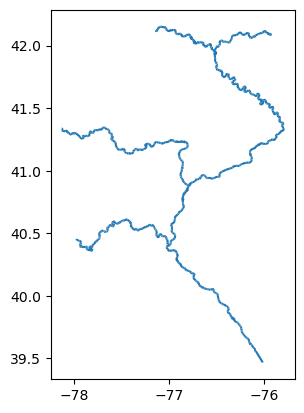

In [21]:

sFilename_geojson = oPyflowline.aBasin[0].sFilename_flowline_filter_geojson
gdf = gpd.read_file(sFilename_geojson)
gdf.plot()
plt.show()



You can also use QGIS.

The plot function provides a few optional arguments such as map projection and spatial extent. 
By default, the spatial extent is full. 
But you can set the extent to a zoom-in region.

now let's run the three major steps/operations one by one.

In [23]:
#run step 1
oPyflowline.pyflowline_flowline_simplification();

Start flowline simplification: 00000001
Basin  00000001  has no dam
Basin  00000001 find flowline vertex
Elapsed time: 0.0031 seconds
Basin  00000001 split flowline
Elapsed time: 6.9848 seconds
Basin  00000001 started correction flow direction
Elapsed time: 2.3375 seconds
Basin  00000001 started loop removal
Elapsed time: 0.6020 seconds
Basin  00000001 started update stream order initial
Elapsed time: 1.0282 seconds
Basin  00000001 find flowline confluence
Elapsed time: 0.0790 seconds
Basin  00000001 started stream segment definition
Elapsed time: 0.0002 seconds
Basin  00000001 started confluence definition
Elapsed time: 0.0195 seconds
Basin  00000001 started stream topology definition
Elapsed time: 0.0002 seconds
Basin  00000001 started stream order definition
Elapsed time: 0.1054 seconds
Finish flowline simplification: 00000001


and check the result using a plot

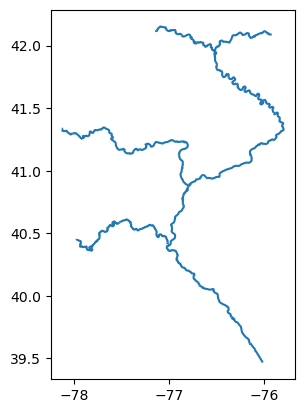

In [24]:
sFilename_geojson = oPyflowline.aBasin[0].sFilename_flowline_simplified
gdf = gpd.read_file(sFilename_geojson)
gdf.plot()
plt.show()

Similarly, we can zoom in using the extent.

Next, we will creata a mesh from the global MPAS mesh.

In [25]:
#run step 2
#we can either use a rectangle boundary
oPyflowline.iFlag_mesh_boundary = 1
aCell = oPyflowline.pyflowline_mesh_generation()

Start mesh generation.
80896
80919
87614
128884
128886
128887
150813
151026
151148
151150
151197
151227
151410
151477
151495
151514
151598
151649
151696
151742
151871
151885
151888
151889
151902
151909
151940
151947
151948
151953
151957
151960
151961
151963
151996
152014
152059
152524
152539
152542
152543
152544
152545
152546
152547
152549
152550
152551
152552
152553
152554
152556
152557
152559
152561
152562
152563
152564
152566
152568
152569
152659
152661
152667
152685
152692
152693
152697
152698
152754
152765
152768
152771
152800
152953
153155
153581
153779
153863
153864
153865
153879
153904
153927
153928
154090
154103
154121
154391
154510
154554
154641
154889
155059
155389
155420
155539
156032
156059
156446
156447
156460
156461
156583
156586
156587
156588
156589
156711
156783
156871
157007
157348
157392
157619
157620
157674
157842
157993
157994
158048
158049
158051
158204
158205
158278
158420
158572
158693
158694
158871
158942
159043
159278
159280
159281
159307
159481
159731
159732


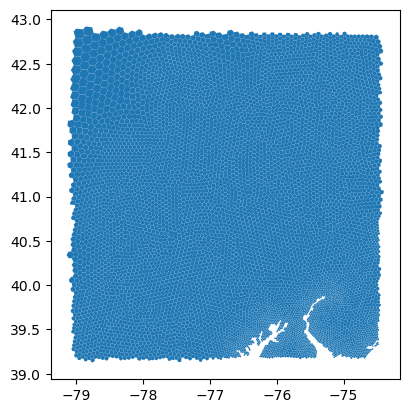

In [26]:

#visualize the mesh
sFilename_geojson = oPyflowline.sFilename_mesh
gdf = gpd.read_file(sFilename_geojson)
gdf.plot()
plt.show()


we can also use a polygon to create a mesh

Last, we can generate the conceptual flowline.

In [29]:
#runs step 3
oPyflowline.pyflowline_reconstruct_topological_relationship();

Start topology reconstruction.
Basin  00000001 Start topology reconstruction
Basin  00000001 Start flowline and mesh intersection
Elapsed time: 240.5310 seconds
Basin  00000001 Start return flowline removal
Elapsed time: 0.9025 seconds
Basin  00000001 Start split flowline to edge
Elapsed time: 0.0067 seconds
Basin  00000001 Start remove duplicate flowline
Elapsed time: 0.0461 seconds
Basin  00000001 Start flowline direction correction
Elapsed time: 0.0589 seconds
Basin  00000001 Start flowline direction correction
Elapsed time: 0.0099 seconds
Basin  00000001 Start find flowline confluence
Elapsed time: 0.0257 seconds
Basin  00000001 Start merge flowline
Elapsed time: 0.0571 seconds
Basin  00000001 Start find flowline confluence
Elapsed time: 0.0005 seconds
Basin  00000001 started stream topology definition
Elapsed time: 0.0000 seconds
Finish topology reconstruction: 00000001
Finish topology reconstruction.


Now we can overlap mesh with flowline.

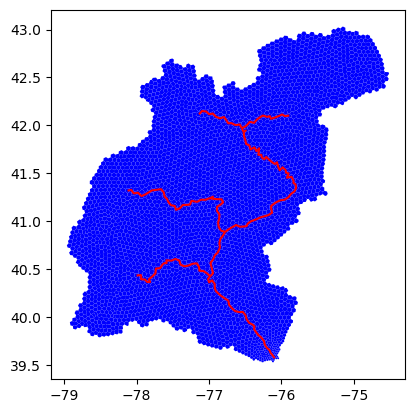

In [30]:


#plot both the mesh and the flowline
sFilename_mesh = oPyflowline.sFilename_mesh
sFilename_conceptual_flowline = oPyflowline.aBasin[0].sFilename_flowline_conceptual
gdf1 = gpd.read_file(sFilename_mesh)
gdf2 = gpd.read_file(sFilename_conceptual_flowline)
fig, ax = plt.subplots()
gdf1.plot(ax=ax, color='blue')
gdf2.plot(ax=ax, color='red')
plt.show()
pass

After this, we can save the model output into a json file.

In [31]:
#export output
oPyflowline.pyflowline_export();

the content of the one of the exported json files can be checked:

In [32]:
with open(oPyflowline.sFilename_mesh_info, 'r') as pJSON:
    parsed = json.load(pJSON)
    print(json.dumps(parsed[0], indent=4))


{
    "aNeighbor": [
        50093,
        50092,
        50091,
        50089,
        50090,
        152720
    ],
    "aNeighbor_distance": [
        5295.051496048625,
        5165.067106140631,
        4704.415782842926,
        5318.332355136824,
        5162.141638508317,
        4709.218245189565
    ],
    "aNeighbor_land": [
        50093,
        50092,
        50091,
        50089,
        50090,
        152720
    ],
    "aNeighbor_land_virtual": [],
    "aVertex": [
        {
            "dLatitude_degree": 42.80697667487519,
            "dLongitude_degree": -75.97185245557154,
            "lVertexID": 335609
        },
        {
            "dLatitude_degree": 42.8297240602518,
            "dLongitude_degree": -75.98534986529103,
            "lVertexID": 248819
        },
        {
            "dLatitude_degree": 42.830899574875005,
            "dLongitude_degree": -76.02873015089585,
            "lVertexID": 191492
        },
        {
            "dLatitude_degree": 4

The outlet associated flowline is always assigned with a dam, because it would be preserved.

Congratulations! You have successfully finished a pyflowline simulation.